In [1]:
%matplotlib notebook
from CG import *

## 12. Preconditioning <a id="12"></a>

Preconditioning is a technique for improving the condition number of a matrix. Suppose that $M$ is a symmetric, positive-definite matrix that approximates $A$, but is easier to invert. We can solve $Ax=b$ indirectly by solving

\begin{equation}
M^{-1}Ax = M^{-1}b. \tag{53}
\end{equation}

If $\kappa(M^{-1}A) \ll \kappa(A)$, or if the eigenvalues of $M^{-1}A$ are better clustered than those of $A$, we can iteratively solve Equation 53 more quickly than the original problem. The catch is that $M^{-1}A$ is not generally symmetric nor definite, even if $M$ and $A$ are.

We can circumvent this difficulty, because for every symmetric, positive-definite $M$ there is a (not necessarily unique) matrix $E$ that has the property that $EE^T=M$. (Such an $E$ can be obtained, for instance, by Cholesky factorization.) The matrices $M^{-1}A$ and $E^{-1}M^{-1}E^{-T}$ have the same eigenvalues. This is true because if $v$ is an eigenvector of $M^{-1}A$ with eigenvalue $\lambda$, then $E^{T}v$ is an eigenvector of $E^{-1}AE^{-T}$ with eigenvalue $\lambda$:

$$
(E^{-1}AE^{-T})(E^Tv) = (E^TE^{-T})E^{-1}Av = E^TM^{-1}Av = \lambda E^Tv.
$$

The system can be transformed into the problem

$$
(E^{-1}AE^{-T})\widehat{x} = E^{-1}b, \qquad \widehat{x}=E^Tx,
$$

which we solve first for $\widehat{x}$, then for $x$. Because $(E^{-1}AE^{-T})$ is symmetric and positive-definite, $\widehat{x}$ can be found by Steepest Descent or CG. The process of using CG to solve this system is called the *Transformed Preconditioned Conjugate Gradient Method*:

\begin{align*}
\widehat{d}_{[0]} = \widehat{r}_{[0]} &= E^{-1}b - E^{-1} A E^{-T} \widehat{x}_{[0]}, \\
\alpha_{[i]} &= \frac{\widehat{r}^T_{[i]} \widehat{r}_{[i]}} {\widehat{d}^T_{[i]} E^{-1} A E^{-T} \widehat{d}_{[i]}}, \\
\widehat{x}_{[i+1]} &= \widehat{x}_{[i]} + \alpha_{[i]} \widehat{d}_{[i]}, \\
\widehat{r}_{[i+1]} &= \widehat{r}_{[i]} - \alpha_{[i]} E^{-1} A E^{-T} \widehat{d}_{[i]}, \\
\beta_{[i+1]} &= \frac{\widehat{r}^T_{[i+1]} \widehat{r}_{[i+1]}} {\widehat{r}^T_{[i]} \widehat{r}_{[i]}}, \\
\widehat{d}_{[i+1]} &= \widehat{r}_{[i+1]} + \beta_{[i+1]} \widehat{d}_{[i]}.
\end{align*}

This method has the undesirable characteristic that $E$ must be computed. However, a few careful variable substitutions can eliminate $E$. Setting $\widehat{r}_{[i]} = E^{-1}r_{[i]}$ and $\widehat{d}_{[i]} = E^T d_{[i]}$, and using the identities $\widehat{x}_{[i]} = E^T x_{[i]}$ and $E^{-T} E^{-1} = M^{-1}$, we derive the *Untransformed Preconditioned Conjugate Gradient Method*:

\begin{align*}
r_{[0]} &= b - A x_{[0]}, \\
d_{[0]} &= M^{-1} r_{[0]}, \\
\alpha_{[i]} &= \frac{r^T_{[i]} M^{-1} r_{[i]}} {d^T_{[i]} A d_{[i]}}, \\
x_{[i+1]} &= x_{[i]} + \alpha_{[i]} d_{[i]}, \\
r_{[i+1]} &= r_{[i]} - \alpha_{[i]} A d_{[i]}, \\
\beta_{[i+1]} &= \frac{r^T_{[i+1]} M^{-1} r_{[i+1]}} {r^T_{[i]} M^{-1} r_{[i]}}, \\
d_{[i+1]} &= M^{-1} r_{[i+1]} + \beta_{[i+1]} d_{[i]}.
\end{align*}

The matrix $E$ does not appear in these equations; only $M^{-1}$ is needed. By the same means, it is possible to derive a Preconditioned Steepest Descent Method that does not use $E$.

The effectiveness of a *preconditioner* $M$ is determined by the condition number of $M^{-1} A$, and occasionally by its clustering of eigenvalues. The problem remains of finding a preconditioner that approximates $A$ well enough to improve convergence enough to make up for the cost of computing the product $M^{-1} r_{[i]}$ once per iteration. (It is not necessary to explicitly compute $M$ or $M^{-1}$; it is only necessary to be able to compute the effect of applying $M^{-1}$ to a vector.) Within this constraint, there is a surprisingly rich supply of possibilities, and I can only scratch the surface here.

Intuitively, preconditioning is an attempt to stretch the quadratic form to make it appear more spherical, so that the eigenvalues are close to each other. A perfect preconditioner is $M=A$; for this preconditioner, $M^{-1} A$ has a condition number of one, and the quadratic form is perfectly spherical, so solution takes only one iteration. Unfortunately, the preconditioning step is solving the system $Mx=b$, so this isn’t a useful preconditioner at all.

The simplest preconditioner is a diagonal matrix whose diagonal entries are identical to those of $A$. The process of applying this preconditioner, known as *diagonal preconditioning* or *Jacobi preconditioning*, is equivalent to scaling the quadratic form along the coordinate axes. (By comparison, the perfect preconditioner $M=A$ scales the quadratic form along its eigenvector axes.) A diagonal matrix is trivial to invert, but is often only a mediocre preconditioner. The contour lines of our sample problem are shown, after diagonal preconditioning, in Figure 36. Comparing with Figure 3, it is clear that some improvement has occurred. The condition number has improved from 3.5 to roughly 2.8. Of course, this improvement is much more beneficial for systems where $n \gg 2$.

<IPython.core.display.Javascript object>


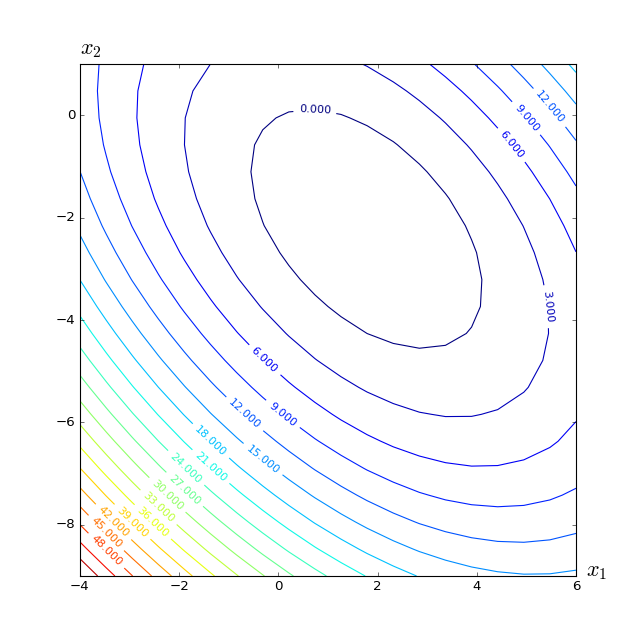

In [2]:
fig36()

<center>Figure 36: Contour lines of the quadratic form of the diagonally preconditioned sample problem.</center>

A more elaborate preconditioner is incomplete Cholesky preconditioning. *Cholesky factorization* is a technique for factoring a matrix $A$ into the form $LL^T$, where $L$ is a lower triangular matrix. Incomplete Cholesky factorization is a variant in which little or no fill is allowed; is approximated by the product $\widehat{L} \widehat{L}^T$, where $\widehat{L}$ might be restricted to have the same pattern of nonzero elements as $A$; other elements of $L$ are thrown away. To use $\widehat{L} \widehat{L}^T$ as a preconditioner, the solution to $\widehat{L} \widehat{L}^Tw = z$ is computed by backsubstitution (the inverse of $\widehat{L} \widehat{L}^T$ is never explicitly computed). Unfortunately, incomplete Cholesky preconditioning is not always stable.

Many preconditioners, some quite sophisticated, have been developed. Whatever your choice, it is generally accepted that for large-scale applications, CG should nearly always be used with a preconditioner.

Next: [13. Conjugate Gradients on the Normal Equations](CG13.ipynb)